In [1]:
#import all relevant libraries
import cleaning as cl
import visualisation as vs
import models as mod
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Machine Leaning Project - Kickstarter
In this project, we analyze the kickstarter dataset and build several machine learning models. Our goal is to help an investor find a project to invest in. The investor is only interested in projects that are going to be successful.

## Import and data cleaning
First, we need to import the data. Then we remove duplicate entries.

In [2]:
#import data and safe it so the df_kick dataframe
df_kick = cl.read_data("data/")
#remove all duplicate entries
df_kick = cl.drop_duplicate(df_kick,"id")


Total number of entries: 209222
Number of unique entries: 182264
Number of rows that will be deleted: 26958


### Further data cleaning
We will drop the missing "blurb" entries, since this is important information we want to have. For now, we'll ignore the missing "location" values as this column might be redundant anyway.

Our analysis and research showed, that the "goal" is in the foreign currency. Since we want to compare all projects in USD, we transform "goal" to USD using the given "static_usd_rate". After that, we remove the now redundant columns

Possible states are live, successful, canceled, failed and suspended.
We drop live states, since they're not finished.
We also drop suspended states, as they are only 600 and we don't know exactly why they have been suspended.

We add canceled to failed, since for our use case the outcome is identical.

Since state is the feature we want to predict, we transform it into a 1/0 categorical variable.

All data cleaning is combined in the following function.

In [3]:
df_kick = cl.clean_data(df_kick)

## Descriptive Statistics
Before building different models, we have a closer look at out data. We look at the distribution of our target feature, the state variable, to see how balanced out dataset is. In addition we look at a correlation matrix, some histograms and pairplots.

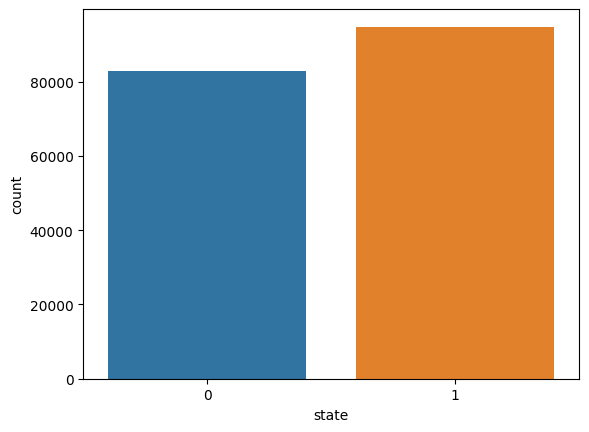

In [4]:
#check how balanced our dataset is
vs.countplot(df_kick, "state")

Out dataset is only slightly unbalaced with approx. 53% of the data being in state 1

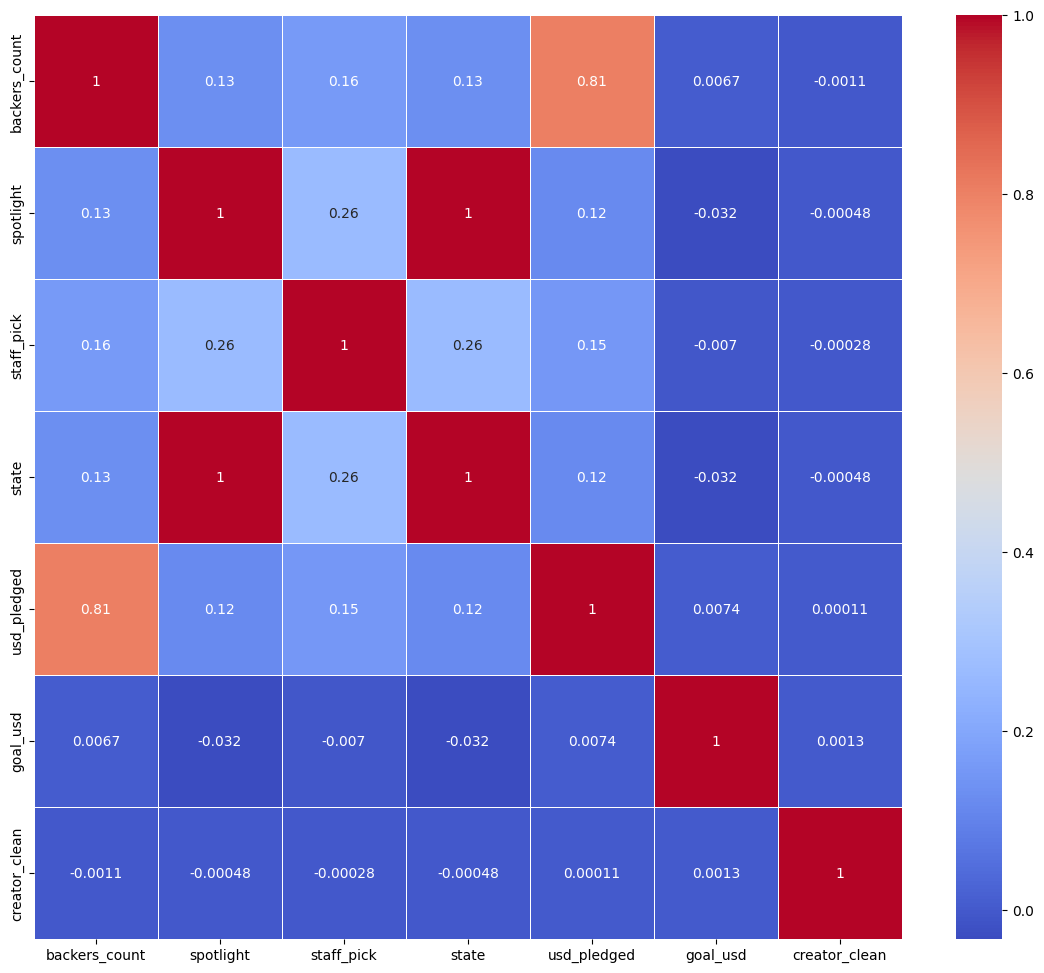

In [5]:
vs.corr_map(df_kick.drop("disable_communication",axis=1))

The features splotlight and state are 100% correlated. Hence, we drop spotlight.

In addition, usd_pledged and backers_count are highly correlated as well. This makes sense. However, we don't want to use these two features for our models since they are not known in advance.

In [6]:
df_kick = df_kick.drop("spotlight", axis=1) 

## Baseline Model
Our baseline model is to simply predict the positive outcome (state=successful) by the value of the goal in USD. As the threshold we choose the mean of all goal_usd values which is 5000$.

Baseline :
Accuracy: 0.5955980473302815
Recall: 0.5729222718112662
Precision: 0.634016766690797


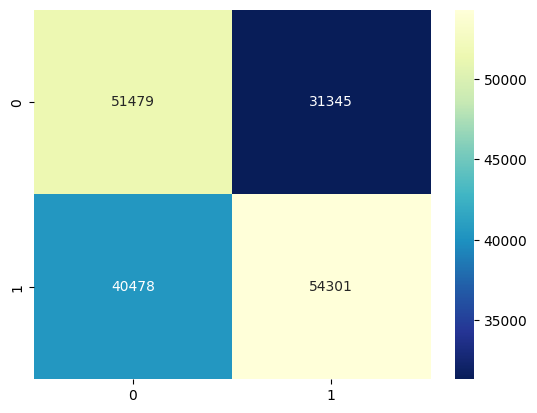

In [7]:
y_pred_baseline = mod.baseline(df_kick,"goal_usd",5000)
mod.eval_metrics(df_kick.state, y_pred_baseline, "Baseline")

So our very basic model is already better than randomly guessing. We chose precision as our main evaluation metric since our stakeholder in interested in accurate information about the probability of success. Our baseline model has a precision of 63%.

Now we try a model that is a little more complex, but still very simple. The model consists of a logistic regression with only one feature.

Logistic Regression :
Accuracy: 0.8295093043551702
Recall: 0.7543572409422203
Precision: 0.9104411014788373


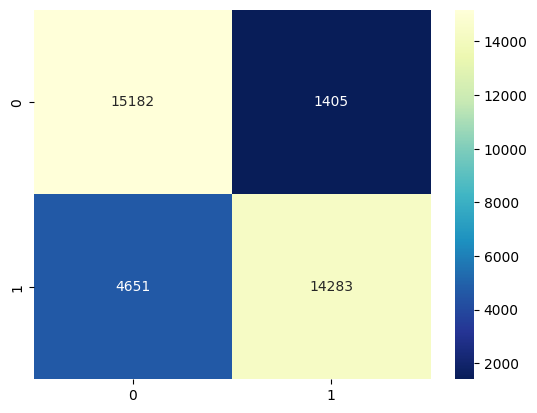

In [8]:
y = df_kick.state
X_simple = df_kick[["backers_count"]]
X_train_simple, X_test_simple, y_train, y_test = train_test_split(X_simple, y, test_size = 0.2, random_state = 0)

y_pred_simple = mod.simple_model(X_train_simple, y_train, X_test_simple)
mod.eval_metrics(y_test, y_pred_simple, "Logistic Regression")


The simple model based on backers_count has a precision of 91%. So backers_count is a very good predictor for the positive or negative outcome of the project. However, backers_count is not know in advance, so we do not use this feature for our models.

## Pipelines

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [10]:
df_kick.columns

Index(['backers_count', 'category', 'country', 'created_at', 'creator',
       'disable_communication', 'slug', 'staff_pick', 'state', 'usd_pledged',
       'goal_usd', 'category_clean', 'creator_clean'],
      dtype='object')

In [11]:
num_features = ["goal_usd"]
cat_features = ["category_clean", "country"] #creator_clean

In [12]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])
# Complete pipeline for numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [47]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])
# Building a full pipeline with our preprocessor and a DecisionTree Classifier
pipe_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier())
])
# Building a full pipeline with our preprocessor and a RandomForest Classifier
pipe_random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestClassifier())
])

In [14]:
#choose our features & build train- and test-set
temp  = cat_features + num_features
X = df_kick[temp]
y = df_kick["state"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [45]:
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': np.logspace(-3,4,10),
                'logreg__solver': ['liblinear', 'lbfgs', 'sag']
               }

rs_logreg = RandomizedSearchCV(pipe_logreg, param_logreg, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1, n_iter=10, random_state=42)

In [ ]:
param_tree = {'tree__criterion': ['gini', 'entropy'],
                'tree__splitter': ['best', 'random'],
                'tree__min_samples_split': range(1,300)
               }

rs_tree = RandomizedSearchCV(pipe_tree, param_tree, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1, n_iter=10, random_state=42)

In [73]:
# Defining parameter space for randomized search. 
param_random_forest = {'random_forest__n_estimators' : range(10,100),
            'random_forest__criterion': ['gini', 'entropy'],
            'random_forest__min_samples_leaf': range(1,300)
               }

rs_random_forest = RandomizedSearchCV(pipe_random_forest, param_random_forest, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1, n_iter=10, random_state = 7)

In [31]:
rs_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.584 total time=   0.2s
[CV 1/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.581 total time=   0.2s
[CV 4/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.587 total time=   0.2s
[CV 3/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.583 total time=   0.2s
[CV 5/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.586 total time=   0.2s
[CV 1/5] END logreg__C=46.41588833612782, logreg__penalty=l1, logreg__solver=liblinear;, score=0.640 total time=   0.3s
[CV 2/5] END logreg__C=46.41588833612782, logreg__penalty=l1, logreg__solver=liblinear;, score=0.648 total time=   0.2s
[CV 3/5] END logreg__C=46.41588833612782, logreg__penalty=l1, logreg__solver=liblinear;, score=0.642 total time=   0.2s
[CV 4/5] END logreg__C=46.4158883361278

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['goal_usd']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('1hot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['category_clean',
                                                                               

In [32]:
# Best score
print('Best score:', round(rs_logreg.best_score_, 3))

# Best parameters
print('Best parameters:', rs_logreg.best_params_)

Best score: 0.644
Best parameters: {'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__C': 278.2559402207126}


Results:
|Best score|solver|penalty|C|
|---|---|---|---|
|0.644|liblinear|l1|100|
|0.644|liblinear|l2|278|

In [ ]:
rs_tree.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.584 total time=   0.2s
[CV 1/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.581 total time=   0.2s
[CV 4/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.587 total time=   0.2s
[CV 3/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.583 total time=   0.2s
[CV 5/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.586 total time=   0.2s
[CV 1/5] END logreg__C=46.41588833612782, logreg__penalty=l1, logreg__solver=liblinear;, score=0.640 total time=   0.3s
[CV 2/5] END logreg__C=46.41588833612782, logreg__penalty=l1, logreg__solver=liblinear;, score=0.648 total time=   0.2s
[CV 3/5] END logreg__C=46.41588833612782, logreg__penalty=l1, logreg__solver=liblinear;, score=0.642 total time=   0.2s
[CV 4/5] END logreg__C=46.4158883361278

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['goal_usd']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('1hot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['category_clean',
                                                                               

In [ ]:
# Best score
print('Best score:', round(rs_tree.best_score_, 3))

# Best parameters
print('Best parameters:', rs_tree.best_params_)

Best score: 0.644
Best parameters: {'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__C': 278.2559402207126}


Results:
|Best score|solver|penalty|C|
|---|---|---|---|
|0.644|liblinear|l1|100|
|0.644|liblinear|l2|278|

In [74]:
rs_random_forest.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END random_forest__criterion=entropy, random_forest__min_samples_leaf=254, random_forest__n_estimators=19;, score=0.653 total time=   1.4s
[CV 4/5] END random_forest__criterion=entropy, random_forest__min_samples_leaf=254, random_forest__n_estimators=19;, score=0.655 total time=   1.4s
[CV 3/5] END random_forest__criterion=entropy, random_forest__min_samples_leaf=254, random_forest__n_estimators=19;, score=0.655 total time=   1.4s
[CV 2/5] END random_forest__criterion=entropy, random_forest__min_samples_leaf=254, random_forest__n_estimators=19;, score=0.658 total time=   1.6s
[CV 5/5] END random_forest__criterion=entropy, random_forest__min_samples_leaf=254, random_forest__n_estimators=19;, score=0.659 total time=   1.5s
[CV 1/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=120, random_forest__n_estimators=42;, score=0.658 total time=   3.8s
[CV 2/5] END random_forest__criterion=gini, random_for

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['goal_usd']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('1hot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['category_clean',
                                                                               

In [75]:
# Best score
print('Best score:', round(rs_random_forest.best_score_, 3))

# Best parameters
print('Best parameters:', rs_random_forest.best_params_)

Best score: 0.661
Best parameters: {'random_forest__n_estimators': 72, 'random_forest__min_samples_leaf': 15, 'random_forest__criterion': 'entropy'}


Results:
|Best score|n_estimators|min_samples_leaf|criterion|
|---|---|---|---|
|0.66|38|14|entropy|
|0.661|72|15|entropy|

In [42]:
# Defining parameter space for grid search.
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag']
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)


param_tree = {'tree__criterion': ['gini', 'entropy'],
                'tree__splitter': ['best', 'random'],
                'tree__min_samples_split': [1, 5, 25, 125, 625]
               }

grid_tree = GridSearchCV(pipe_tree, param_grid=param_tree, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)


param_random_forest = {'random_forest__n_estimators' : [50, 100, 150, 200],
            'random_forest__criterion': ['gini', 'entropy'],
            'random_forest__min_samples_leaf': [1, 5, 25, 125, 625],
            'random_forest__max_depth': [None, 10, 20, 30, 50]
               }

grid_random_forest = GridSearchCV(pipe_random_forest, param_grid=param_random_forest, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

In [ ]:
grid_logreg.fit(X_train, y_train)

In [ ]:
grid_tree.fit(X_train, y_train)

In [ ]:
grid_random_forest.fit(X_train, y_train)

In [ ]:
# Show best parameters
print('Best score logreg:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters logreg:\n{}".format(grid_logreg.best_params_))
print('Best score tree:\n{:.2f}'.format(grid_tree.best_score_))
print("Best parameters tree:\n{}".format(grid_tree.best_params_))
print('Best score random forest:\n{:.2f}'.format(grid_random_forest.best_score_))
print("Best parameters random forest:\n{}".format(grid_random_forest.best_params_))

In [ ]:
# Save best model (including fitted preprocessing steps) as best_model 
best_model_logreg = grid_logreg.best_estimator_
best_model_tree = grid_tree.best_estimator_
best_model_random_forest = grid_random_forest.best_estimator_


In [ ]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_train_predicted_logreg = best_model_logreg.predict(X_train)
y_train_predicted_tree = best_model_tree.predict(X_train)
y_train_predicted_random_forest = best_model_random_forest.predict(X_train)
y_test_predicted_logreg = best_model_logreg.predict(X_test)
y_test_predicted_tree = best_model_tree.predict(X_test)
y_test_predicted_random_forest = best_model_random_forest.predict(X_test)


In [ ]:
mod.eval_metrics(y_train,y_train_predicted_logreg, "logistic regression - train", False)
mod.eval_metrics(y_test,y_test_predicted_logreg, "logistic regression - test", False)
mod.eval_metrics(y_train,y_train_predicted_tree, "decision tree - train", False)
mod.eval_metrics(y_test,y_test_predicted_tree, "decision tree - test", False)
mod.eval_metrics(y_train,y_train_predicted_random_forest, "random forest - train", False)
mod.eval_metrics(y_test,y_test_predicted_random_forest, "random forest - test", False)

In [ ]:
#Max Voting
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(random_state = 24)
model2 =  DecisionTreeClassifier(random_state = 24)
model3 = RandomForestClassifier(random_state = 24)

model = VotingClassifier(estimators = [('lr', model1), ('dt', model2), ('rf', model3)], voting = 'hard')
model.fit(X_train,y_train)
model.score(X_test,y_test)

In [ ]:
y_test_predicted_voting = model.predict(X_test)
y_train_predicted_voting = model.predict(X_train)

In [ ]:
mod.eval_metrics(y_train,y_train_predicted_voting, "voting - train", False)
mod.eval_metrics(y_test,y_test_predicted_voting, "voting - test", False)